In [1]:
#pip install datasets pillow pandas tqdm

In [1]:

## STEP 1: IMPORTS AND CONFIGURATION

import os
import json
from datasets import load_dataset
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import random

c:\Users\yoges\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## STEP 2: LOAD COCO DATASET FROM HUGGING FACE

print("📥 Loading COCO dataset in STREAMING mode (no download)...")
dataset = load_dataset("detection-datasets/coco", split="train", streaming=True)
print("✅ Dataset loaded in streaming mode!")

📥 Loading COCO dataset in STREAMING mode (no download)...
✅ Dataset loaded in streaming mode!


In [3]:
COCO_CLASSES = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra",
    "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
    "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush",
]
TARGET_NAMES = {
    'person',
    'bicycle',
    'car',
    'motorcycle',
    'airplane',
    'bus',
    'truck',
    'traffic light',
    'stop sign',
    'bench',
    'bird',
    'cat',
    'dog',
    'horse',
    'cow',
    'elephant',
    'bottle',
    'cup',
    'bowl',
    'pizza',
    'cake',
    'chair',
    'couch',
    'bed',
    'potted plant',
}

SELECTED_CLASSES = {
    name: COCO_CLASSES.index(name)
    for name in TARGET_NAMES
}
IMAGES_PER_CLASS = 100
BASE_DIR = "smartvision_dataset"

In [ ]:
## STEP 3: COLLECT IMAGES FROM STREAM

print("\n🔍 Starting image collection from COCO dataset stream...")
print(f"🎯 Target: {IMAGES_PER_CLASS} images per class")
print()

# Initialize storage for collected images
class_images = {class_name: [] for class_name in SELECTED_CLASSES.keys()}
class_counts = {class_name: 0 for class_name in SELECTED_CLASSES.keys()}

# Progress tracking
total_collected = 0
images_processed = 0
max_iterations = 50000  # Safety limit

print("⏳ Processing images from stream...")
print("💡 Progress updates every 100 images collected")
print()

# Iterate through streaming dataset
for idx, item in enumerate(dataset):

    images_processed += 1

    # Progress update every 1000 images processed
    if images_processed % 1000 == 0:
        print(f"📊 Processed {images_processed} images | Collected {total_collected}/{len(SELECTED_CLASSES) * IMAGES_PER_CLASS}")

    # Safety check
    if images_processed >= max_iterations:
        print(f"⚠️ Reached safety limit of {max_iterations} iterations")
        break

    # Check if we have enough images for ALL classes
    if all(count >= IMAGES_PER_CLASS for count in class_counts.values()):
        print("🎉 Successfully collected 100 images for ALL classes!")
        break

    # Get annotations from current image
    annotations = item['objects']
    categories = annotations['category']

    # Check if any of our target classes are in this image
    for cat_id in categories:
        for class_name, class_id in SELECTED_CLASSES.items():
            if cat_id == class_id and class_counts[class_name] < IMAGES_PER_CLASS:

                # Store the ACTUAL image data (not just index!)
                class_images[class_name].append({
                    'image': item['image'],           # PIL Image object
                    'annotations': item['objects'],   # Annotations
                    'idx': images_processed           # For naming
                })

                class_counts[class_name] += 1
                total_collected += 1

                # Progress update every 100 collected
                if total_collected % 100 == 0:
                    print(f"✓ Collected {total_collected}/{len(SELECTED_CLASSES) * IMAGES_PER_CLASS} images")

                break  # Only count once per class

print()
print("="*60)
print("📊 COLLECTION COMPLETE:")
print("="*60)
print(f"Images Processed: {images_processed}")
print(f"Images Collected: {total_collected}")
print()
for class_name, count in sorted(class_counts.items()):
    status = "✅" if count >= IMAGES_PER_CLASS else "⚠️"
    print(f"{status} {class_name:20s}: {count:3d} images")
print("="*60)


🔍 Starting image collection from COCO dataset stream...
🎯 Target: 100 images per class

⏳ Processing images from stream...
💡 Progress updates every 100 images collected

✓ Collected 100/2500 images
✓ Collected 200/2500 images
✓ Collected 300/2500 images
✓ Collected 400/2500 images
✓ Collected 500/2500 images
✓ Collected 600/2500 images
✓ Collected 700/2500 images
✓ Collected 800/2500 images
✓ Collected 900/2500 images
✓ Collected 1000/2500 images
✓ Collected 1100/2500 images
✓ Collected 1200/2500 images
✓ Collected 1300/2500 images
✓ Collected 1400/2500 images
✓ Collected 1500/2500 images
✓ Collected 1600/2500 images
📊 Processed 1000 images | Collected 1642/2500
✓ Collected 1700/2500 images
✓ Collected 1800/2500 images
✓ Collected 1900/2500 images
✓ Collected 2000/2500 images
✓ Collected 2100/2500 images
✓ Collected 2200/2500 images
📊 Processed 2000 images | Collected 2273/2500
✓ Collected 2300/2500 images
✓ Collected 2400/2500 images


In [ ]:
## STEP 4: CREATE FOLDER STRUCTURE

print("\n📁 Creating project folder structure...")
print()

# Create main directory
os.makedirs(BASE_DIR, exist_ok=True)

# Create subdirectories for Classification task
os.makedirs(f"{BASE_DIR}/classification/train", exist_ok=True)
os.makedirs(f"{BASE_DIR}/classification/val", exist_ok=True)
os.makedirs(f"{BASE_DIR}/classification/test", exist_ok=True)

# Create subdirectories for Detection task
os.makedirs(f"{BASE_DIR}/detection/images", exist_ok=True)
os.makedirs(f"{BASE_DIR}/detection/labels", exist_ok=True)

# Create class folders inside train/val/test
for class_name in SELECTED_CLASSES.keys():
    os.makedirs(f"{BASE_DIR}/classification/train/{class_name}", exist_ok=True)
    os.makedirs(f"{BASE_DIR}/classification/val/{class_name}", exist_ok=True)
    os.makedirs(f"{BASE_DIR}/classification/test/{class_name}", exist_ok=True)

print("✅ Folder structure created successfully!")
print()
print("📂 Structure:")
print(f"""
{BASE_DIR}/
├── classification/
│   ├── train/
│   │   ├── person/
│   │   ├── car/
│   │   └── ... (25 class folders)
│   ├── val/
│   │   └── ... (25 class folders)
│   └── test/
│       └── ... (25 class folders)
│
└── detection/
    ├── images/
    └── labels/
""")


📁 Creating project folder structure...

✅ Folder structure created successfully!

📂 Structure:

smartvision_dataset/
├── classification/
│   ├── train/
│   │   ├── person/
│   │   ├── car/
│   │   └── ... (25 class folders)
│   ├── val/
│   │   └── ... (25 class folders)
│   └── test/
│       └── ... (25 class folders)
│
└── detection/
    ├── images/
    └── labels/



In [ ]:
## STEP 5: TRAIN/VAL/TEST SPLIT (70/15/15)

print("="*70)
print("🔀 Preparing Train/Val/Test splits...")
print("📊 Split Ratio: 70% Train / 15% Val / 15% Test")
print("="*70)
print()

# Initialize metadata dictionary
metadata = {
    'total_images': 0,
    'classes': {},
    'splits': {'train': 0, 'val': 0, 'test': 0}
}

# Create split dictionaries for each class
train_data = {}
val_data = {}
test_data = {}

# Process each class
for class_name in SELECTED_CLASSES.keys():

    all_items = class_images.get(class_name, [])

    if not all_items:
        print(f"⚠️ Warning: No images found for {class_name}")
        continue

    # Calculate split indices
    random.shuffle(all_items)
    n = len(all_items)
    train_split = int(0.7 * n)   # 70% for training
    val_split = int(0.85 * n)    # 15% for validation
    # Remaining 15% for test

    # Split the data
    train_data[class_name] = all_items[:train_split]
    val_data[class_name] = all_items[train_split:val_split]
    test_data[class_name] = all_items[val_split:]

    # Store split info in metadata
    metadata['classes'][class_name] = {
        'train': len(train_data[class_name]),
        'val': len(val_data[class_name]),
        'test': len(test_data[class_name]),
        'total': len(all_items)
    }

    metadata['splits']['train'] += len(train_data[class_name])
    metadata['splits']['val'] += len(val_data[class_name])
    metadata['splits']['test'] += len(test_data[class_name])
    metadata['total_images'] += len(all_items)

    print(f"{class_name:20s}: Train={len(train_data[class_name]):3d} | Val={len(val_data[class_name]):2d} | Test={len(test_data[class_name]):2d}")

🔀 Preparing Train/Val/Test splits...
📊 Split Ratio: 70% Train / 15% Val / 15% Test

motorcycle          : Train= 70 | Val=15 | Test=15
airplane            : Train= 70 | Val=15 | Test=15
bowl                : Train= 70 | Val=15 | Test=15
chair               : Train= 70 | Val=15 | Test=15
bird                : Train= 70 | Val=15 | Test=15
car                 : Train= 70 | Val=15 | Test=15
truck               : Train= 70 | Val=15 | Test=15
horse               : Train= 70 | Val=15 | Test=15
dog                 : Train= 70 | Val=15 | Test=15
couch               : Train= 70 | Val=15 | Test=15
bench               : Train= 70 | Val=15 | Test=15
pizza               : Train= 70 | Val=15 | Test=15
bed                 : Train= 70 | Val=15 | Test=15
elephant            : Train= 70 | Val=15 | Test=15
bicycle             : Train= 70 | Val=15 | Test=15
bus                 : Train= 70 | Val=15 | Test=15
stop sign           : Train= 70 | Val=15 | Test=15
bottle              : Train= 70 | Val=15 | Test=1

In [ ]:
import os
from PIL import Image
from tqdm import tqdm
import json

print("="*70)
print("💾 STEP 6: SAVING IMAGES TO DISK")
print("="*70)
print()

# PART A: SAVE CLASSIFICATION IMAGES


print("📁 PART A: Saving Classification Images...")
print("   Format: Cropped objects, 224x224 pixels\n")

classification_stats = {'train': 0, 'val': 0, 'test': 0}

# Process each split
for split_name, split_data in [('train', train_data), ('val', val_data), ('test', test_data)]:

    print(f"📂 Processing {split_name.upper()} split...")

    # Process each class
    for class_name, items in tqdm(split_data.items(), desc=f"  {split_name}"):

        class_folder = f"{BASE_DIR}/classification/{split_name}/{class_name}"

        # Save each image
        for img_idx, item in enumerate(items):

            img = item['image']
            annotations = item['annotations']
            bboxes = annotations['bbox']
            categories = annotations['category']

            class_id = SELECTED_CLASSES[class_name]

            # Find bbox for this class
            for bbox, cat_id in zip(bboxes, categories):
                if cat_id == class_id:
                    x, y, w, h = bbox

                    try:
                        # Crop and resize
                        cropped_img = img.crop((x, y, x + w, y + h))
                        cropped_img = cropped_img.resize((224, 224), Image.LANCZOS)

                        # Save
                        img_filename = f"{class_name}_{split_name}_{img_idx:04d}.jpg"
                        img_path = os.path.join(class_folder, img_filename)
                        cropped_img.save(img_path, quality=95)

                        classification_stats[split_name] += 1

                    except Exception as e:
                        print(f"⚠️ Error: {class_name} image {img_idx}: {e}")

                    break

print()
print("="*70)
print("✅ CLASSIFICATION IMAGES SAVED!")
print("="*70)
print(f"📊 Train: {classification_stats['train']} images")
print(f"📊 Val:   {classification_stats['val']} images")
print(f"📊 Test:  {classification_stats['test']} images")
print(f"📊 Total: {sum(classification_stats.values())} images")
print()

💾 STEP 6: SAVING IMAGES TO DISK

📁 PART A: Saving Classification Images...
   Format: Cropped objects, 224x224 pixels

📂 Processing TRAIN split...


  train: 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


📂 Processing VAL split...


  val: 100%|██████████| 25/25 [00:01<00:00, 19.52it/s]


📂 Processing TEST split...


  test: 100%|██████████| 25/25 [00:01<00:00, 16.49it/s]


✅ CLASSIFICATION IMAGES SAVED!
📊 Train: 1750 images
📊 Val:   375 images
📊 Test:  375 images
📊 Total: 2500 images



In [ ]:
from tqdm import tqdm
import os

print("="*70)
print("📁 PART B (NEW): Saving Detection Images & Annotations")
print("   - Separate train/val/test folders")
print("   - Robust class-name mapping from COCO → YOLO")
print("="*70)

# 25 SmartVision YOLO classes (index 0..24)
YOLO_CLASS_NAMES = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus",
    "truck", "traffic light", "stop sign", "bench", "bird", "cat",
    "dog", "horse", "cow", "elephant", "bottle", "cup", "bowl",
    "pizza", "cake", "chair", "couch", "bed", "potted plant",
]

# COCO index → class name (same list you used earlier)
COCO_INDEX_TO_NAME = {i: name for i, name in enumerate(COCO_CLASSES)}

# class name → YOLO index (0..24)
NAME_TO_YOLO = {name: i for i, name in enumerate(YOLO_CLASS_NAMES)}

# Create split folders for detection
DET_IMG_ROOT = os.path.join(BASE_DIR, "detection", "images")
DET_LAB_ROOT = os.path.join(BASE_DIR, "detection", "labels")

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(DET_IMG_ROOT, split), exist_ok=True)
    os.makedirs(os.path.join(DET_LAB_ROOT, split), exist_ok=True)

# We will reuse your train_data, val_data, test_data
split_dicts = {
    "train": train_data,
    "val":   val_data,
    "test":  test_data,
}

detection_stats = {
    "train": {"images": 0, "annotations": 0, "objects": 0},
    "val":   {"images": 0, "annotations": 0, "objects": 0},
    "test":  {"images": 0, "annotations": 0, "objects": 0},
}

global_img_idx = 0  # unique id across all splits

for split_name, split_data in split_dicts.items():
    print(f"\n🔹 Building detection {split_name.upper()} split...")

    for class_name, items in tqdm(split_data.items(), desc=f"{split_name} classes"):
        for item in items:
            img = item["image"]
            img_w, img_h = img.size

            img_filename = f"image_{global_img_idx:06d}.jpg"
            img_path = os.path.join(DET_IMG_ROOT, split_name, img_filename)
            lab_path = os.path.join(DET_LAB_ROOT, split_name, img_filename.replace(".jpg", ".txt"))

            # Full image saved once per entry
            img.save(img_path, quality=95)
            detection_stats[split_name]["images"] += 1
            global_img_idx += 1

            annotations = item["annotations"]
            bboxes = annotations["bbox"]
            categories = annotations["category"]

            yolo_lines = []
            obj_count = 0

            for bbox, cat_id in zip(bboxes, categories):
                coco_name = COCO_INDEX_TO_NAME.get(cat_id, None)
                if coco_name is None:
                    continue

                # Only keep our 25 target classes
                if coco_name not in NAME_TO_YOLO:
                    continue

                yolo_id = NAME_TO_YOLO[coco_name]

                x, y, w, h = bbox  # COCO: [x_min, y_min, width, height]

                # Convert to YOLO normalized format
                x_center = (x + w / 2) / img_w
                y_center = (y + h / 2) / img_h
                w_norm   = w / img_w
                h_norm   = h / img_h

                yolo_lines.append(
                    f"{yolo_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
                )
                obj_count += 1

            if yolo_lines:
                with open(lab_path, "w") as f:
                    f.write("\n".join(yolo_lines))
                detection_stats[split_name]["annotations"] += 1
                detection_stats[split_name]["objects"] += obj_count

print("\n✅ DETECTION SPLITS CREATED!")
for split in ["train", "val", "test"]:
    s = detection_stats[split]
    print(f"{split.upper():5s} → images: {s['images']}, label_files: {s['annotations']}, objects: {s['objects']}")


📁 PART B: Saving Detection Images & Annotations...
   Format: Full images with YOLO .txt labels

📊 Total detection images: 2125



Saving detection data: 100%|██████████| 2125/2125 [00:09<00:00, 236.00it/s]


✅ DETECTION DATASET CREATED!
📊 Images:     2125
📊 Labels:     2125
📊 Objects:    21519
📊 Avg/image:  10.13



In [ ]:
print("📝 Creating YOLO configuration file with train/val/test splits...\n")

yaml_content = f"""# SmartVision Dataset - YOLOv8 Configuration (with splits)
path: {os.path.abspath(DET_DIR)}

train: images/train
val: images/val
test: images/test

names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: truck
  7: traffic light
  8: stop sign
  9: bench
  10: bird
  11: cat
  12: dog
  13: horse
  14: cow
  15: elephant
  16: bottle
  17: cup
  18: bowl
  19: pizza
  20: cake
  21: chair
  22: couch
  23: bed
  24: potted plant

nc: 25
"""

yaml_path = os.path.join(DET_DIR, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"✅ Created: {yaml_path}")


📝 Creating YOLO configuration file...

✅ Created: smartvision_dataset/detection/data.yaml



In [ ]:
# PART D: SAVE METADATA

print("📊 Saving metadata...\n")

metadata['classification'] = classification_stats
metadata['detection'] = detection_stats
metadata['dataset_path'] = os.path.abspath(BASE_DIR)

metadata_path = f"{BASE_DIR}/dataset_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, indent=2, fp=f)

print(f"✅ Saved: {metadata_path}\n")

📊 Saving metadata...

✅ Saved: smartvision_dataset/dataset_metadata.json



In [12]:
print("="*70)
print("🎉 DATASET SETUP COMPLETE!")
print("="*70)
print()
print(f"📁 Location: {os.path.abspath(BASE_DIR)}")
print()
print("📂 Classification Dataset:")
print(f"   ├─ Train:  {classification_stats['train']} images (70%)")
print(f"   ├─ Val:    {classification_stats['val']} images (15%)")
print(f"   ├─ Test:   {classification_stats['test']} images (15%)")
print(f"   └─ Total:  {sum(classification_stats.values())} cropped images (224x224)")
print()
print("📂 Detection Dataset:")
print(f"   ├─ Images: {detection_stats['images']} full images")
print(f"   ├─ Labels: {detection_stats['annotations']} YOLO .txt files")
print(f"   └─ Objects: {detection_stats['objects']} annotated objects")
print()
print("="*70)
print("✅ LEARNERS CAN NOW START:")
print("="*70)
print("Step 7:  Exploratory Data Analysis (EDA)")
print("Step 8:  Train Classification Models")
print("Step 9:  Train YOLO Detection Model")
print("Step 10: Build Streamlit Application")
print("Step 11: Deploy to Hugging Face Spaces")
print("="*70)

🎉 DATASET SETUP COMPLETE!

📁 Location: d:\Guvi\SmartVision_AI\smartvision_dataset

📂 Classification Dataset:
   ├─ Train:  1750 images (70%)
   ├─ Val:    375 images (15%)
   ├─ Test:   375 images (15%)
   └─ Total:  2500 cropped images (224x224)

📂 Detection Dataset:
   ├─ Images: 2125 full images
   ├─ Labels: 2125 YOLO .txt files
   └─ Objects: 21519 annotated objects

✅ LEARNERS CAN NOW START:
Step 7:  Exploratory Data Analysis (EDA)
Step 8:  Train Classification Models
Step 9:  Train YOLO Detection Model
Step 10: Build Streamlit Application
Step 11: Deploy to Hugging Face Spaces


In [13]:
class_images
train_data, val_data, test_data
n = len(all_items)
BASE_DIR


'smartvision_dataset'

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import ImageDraw, ImageFont


In [16]:
# Count collected images
counts = {cls: len(class_images[cls]) for cls in n = len(all_items).keys()}

plt.figure(figsize=(14,6))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
plt.xticks(rotation=90)

plt.title("Class Distribution in the Dataset (Before Splits)", fontsize=16)
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.show()


SyntaxError: invalid syntax (377561577.py, line 2)

In [17]:
objects_per_image = []

for cls in n = len(all_items).keys():
    for item in class_images[cls]:
        objects_per_image.append(len(item['annotations']['category']))

plt.figure(figsize=(10,5))
sns.histplot(objects_per_image, bins=20, kde=True)
plt.title("Objects per Image Distribution", fontsize=16)
plt.xlabel("Number of Objects in Image")
plt.ylabel("Frequency")
plt.show()

print(f"Average objects per image: {np.mean(objects_per_image):.2f}")


SyntaxError: invalid syntax (2411221815.py, line 3)

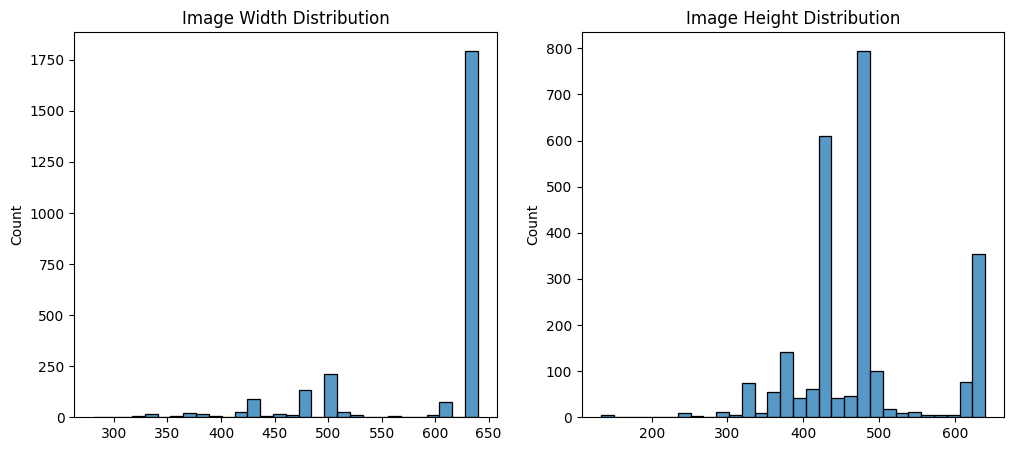

Average size: 595.7 x 474.6


In [ ]:
widths = []
heights = []

for cls in SELECTED_CLASSES.keys():
    for item in class_images[cls]:
        w, h = item['image'].size
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(widths, bins=30)
plt.title("Image Width Distribution")

plt.subplot(1,2,2)
sns.histplot(heights, bins=30)
plt.title("Image Height Distribution")

plt.show()

print(f"Average size: {np.mean(widths):.1f} x {np.mean(heights):.1f}")


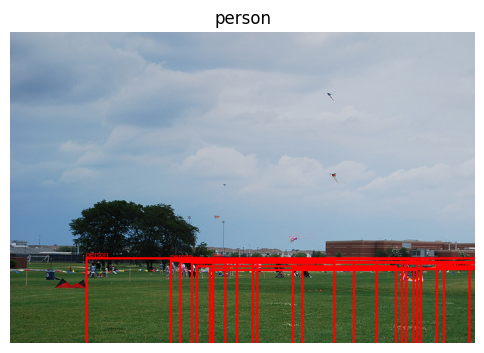

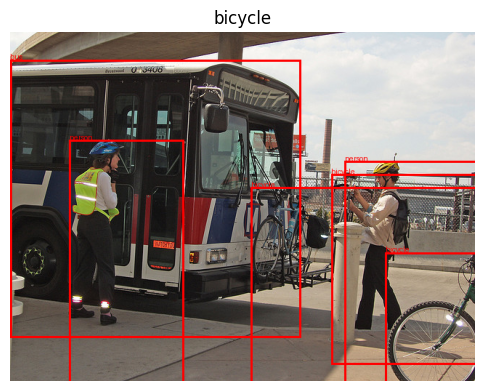

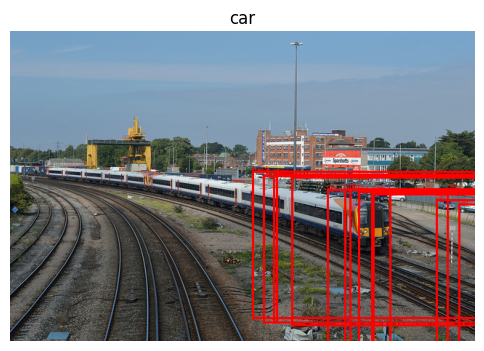

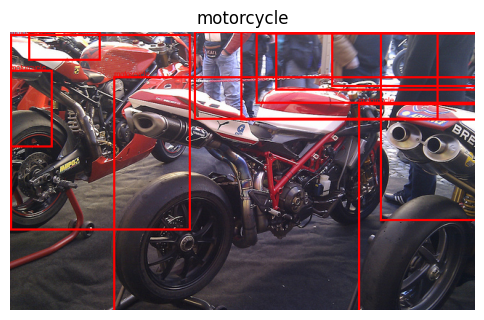

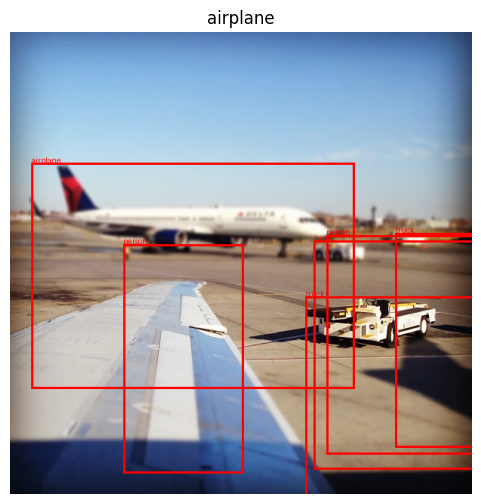

In [18]:
import random

def visualize_sample(class_name):
    item = random.choice(class_images[class_name])
    img = item['image'].copy()
    draw = ImageDraw.Draw(img)

    boxes = item['annotations']['bbox']
    categories = item['annotations']['category']

    for bbox, cat_id in zip(boxes, categories):
        if cat_id in SELECTED_CLASSES.values():
            x, y, w, h = bbox
            name = list(SELECTED_CLASSES.keys())[list(SELECTED_CLASSES.values()).index(cat_id)]

            draw.rectangle((x, y, x+w, y+h), outline="red", width=3)
            draw.text((x, y - 10), name, fill="red")

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(class_name)
    plt.show()

# Show 5 samples
for cls in list(SELECTED_CLASSES.keys())[:5]:
    visualize_sample(cls)


C:\Users\yoges\AppData\Local\Temp\ipykernel_632\3716179233.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(split_counts.keys()), y=list(split_counts.values()), palette="magma")


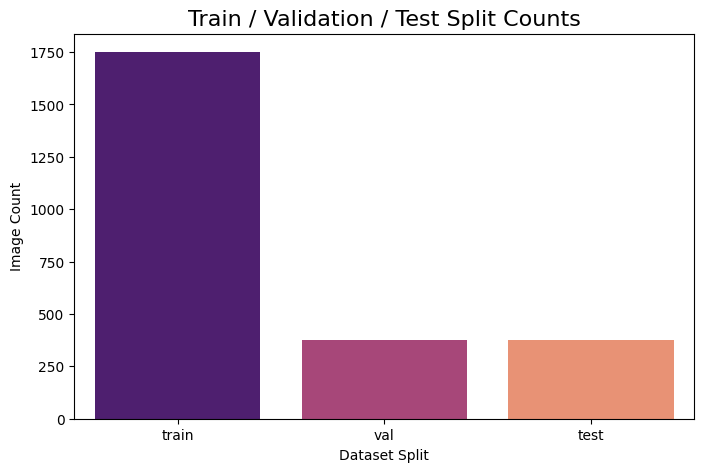

{'train': 1750, 'val': 375, 'test': 375}


In [ ]:
# Collect split counts
split_counts = {
    'train': sum(len(v) for v in train_data.values()),
    'val': sum(len(v) for v in val_data.values()),
    'test': sum(len(v) for v in test_data.values())
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(split_counts.keys()), y=list(split_counts.values()), palette="magma")
plt.title("Train / Validation / Test Split Counts", fontsize=16)
plt.ylabel("Image Count")
plt.xlabel("Dataset Split")
plt.show()

print(split_counts)
